# EDA and Baseline Audio Features for Egyptian Fruit Bat 10k Dataset

This notebook performs exploratory data analysis (EDA), resampling of audio to lower sample rates (48 kHz), and computation of mel-spectrogram features for the ~10k subset stored in `data/annotations.csv`.

**Important:** This notebook does **not** modify files under `data/`; all derived artifacts are written to new folders under `derived/`.

In [ ]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf

sns.set_theme(context="notebook", style="whitegrid")

ROOT = Path.cwd().resolve()  # launched kernel in starter_code/
DATA_DIR = ROOT / "data"
DERIVED_DIR = ROOT / "derived"
AUDIO_DIR = DATA_DIR / "audio"
DERIVED_AUDIO_48K = DERIVED_DIR / "audio_48k"
DERIVED_MELS_48K = DERIVED_DIR / "mels_48k"

DERIVED_DIR.mkdir(exist_ok=True)
DERIVED_AUDIO_48K.mkdir(exist_ok=True, parents=True)
DERIVED_MELS_48K.mkdir(exist_ok=True, parents=True)

# should be starter_code/
print("ROOT:", ROOT)


ROOT: /Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/starter_code


In [15]:
# Load annotations: 10k subset and full annotations with richer labels
ann_small = pd.read_csv(DATA_DIR / "annotations.csv")
ann_full = pd.read_csv(ROOT / "annotations_filenames.csv")

print("ann_small shape:", ann_small.shape)
print("ann_full shape :", ann_full.shape)

# Merge to bring richer labels onto the 10k subset (join on Emitter + File Name)
ann = ann_small.merge(
    ann_full,
    on=["Emitter", "File Name"],
    how="left",
)

print("Merged shape (10k with full labels):", ann.shape)
missing_fileid = ann['FileID'].isna().sum() if 'FileID' in ann.columns else 0
print("Rows with missing FileID after merge:", missing_fileid)
print(len(ann)) # should be 10000
ann.head() # should have all columns along with file name

ann_small shape: (10000, 2)
ann_full shape : (91080, 11)
Merged shape (10k with full labels): (10000, 11)
Rows with missing FileID after merge: 0
10000


,Emitter,File Name,FileID,Addressee,Context,Emitter pre-vocalization action,Addressee pre-vocalization action,Emitter post-vocalization action,Addressee post-vocalization action,Start sample,End sample
0,216,69809.wav,233219,221,11,2,3,3,3,1,590672
1,215,71889.wav,237330,220,12,2,2,3,3,1,328528
2,216,46690.wav,173649,231,12,2,2,3,3,1,467792
3,230,85411.wav,268012,221,12,2,2,3,3,1,475984
4,215,45609.wav,170616,220,12,2,2,3,3,1,336720


In [16]:
# save the merged 10k annotations (with full labels) for reuse
# writes `annotations_10k.csv` into the `starter_code/` directory.
ann.to_csv(ROOT / "annotations_10k.csv", index=False)
print("Wrote annotations_10k.csv with shape:", ann.shape)

Wrote annotations_10k.csv with shape: (10000, 11)


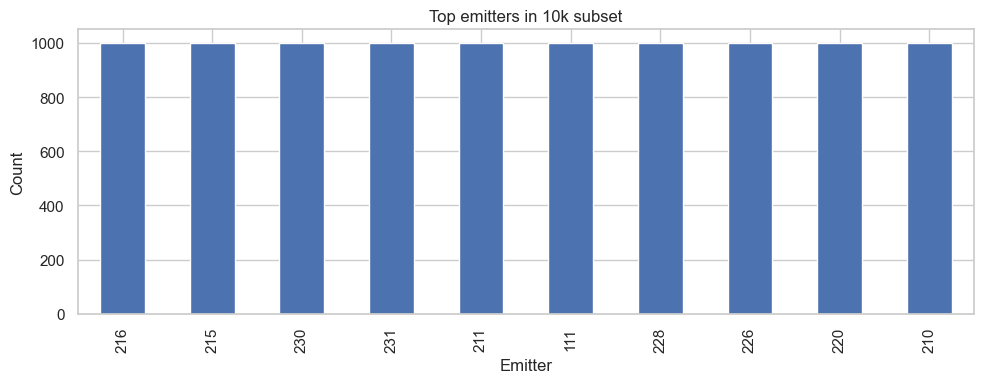

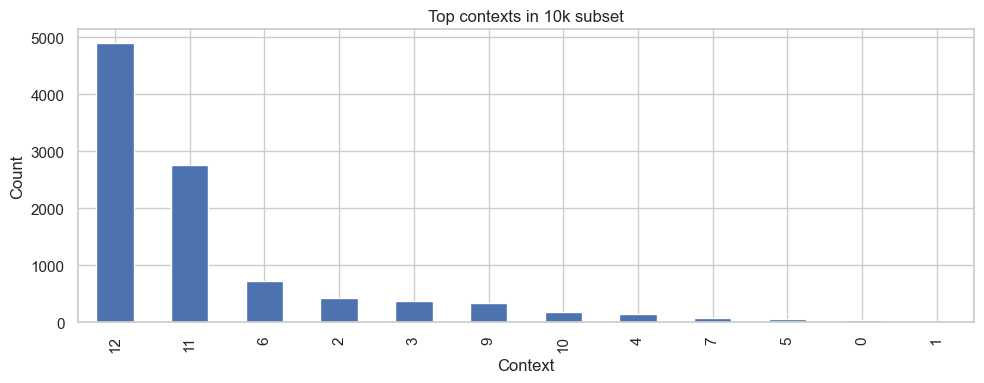

In [8]:
# Basic EDA on labels in the 10k subset
plt.figure(figsize=(10, 4))
ann['Emitter'].value_counts().head(20).plot(kind='bar')
plt.title('Top emitters in 10k subset')
plt.xlabel('Emitter')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

if 'Context' in ann.columns:
    plt.figure(figsize=(10, 4))
    ann['Context'].value_counts().head(20).plot(kind='bar')
    plt.title('Top contexts in 10k subset')
    plt.xlabel('Context')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


Unique sample rates in sample: [250000]
Duration stats (seconds) in sample:
count    10000.000000
mean         1.877032
std          1.081140
min          0.047988
25%          1.314108
50%          1.445180
75%          2.133308
max         21.859644
dtype: float64


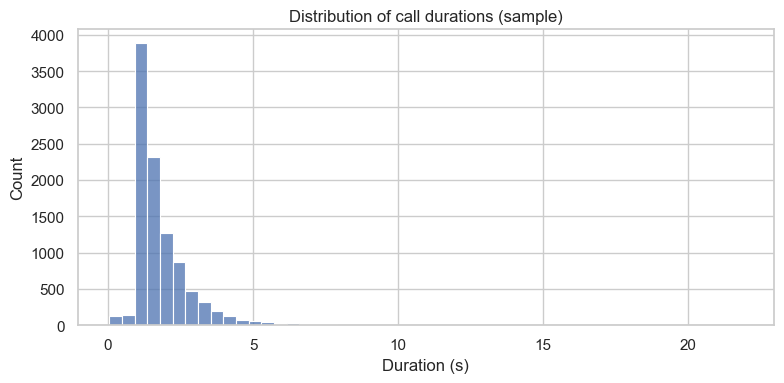

In [ ]:
# Inspect audio durations
from typing import Tuple

def get_duration_and_sr(path: Path) -> Tuple[float, int]:
    y, sr = librosa.load(path, sr=None)  # keep native 250 kHz
    return float(len(y)) / float(sr), int(sr)

sample_n = None  # None for all files, or smaller/larger to scan N files
paths = [AUDIO_DIR / fn for fn in ann_small['File Name'][:sample_n]]

durations = []
srs = []
for p in paths:
    if not p.exists():
        continue
    d, sr = get_duration_and_sr(p)
    durations.append(d)
    srs.append(sr)

print("Unique sample rates in sample:", sorted(set(srs)))
print("Duration stats (seconds) in sample:")
print(pd.Series(durations).describe())

plt.figure(figsize=(8, 4))
sns.histplot(durations, bins=50, kde=False)
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('Distribution of call durations (sample)')
plt.tight_layout()
plt.show()


## Resample audio to 48 kHz

The code below creates a *separate* downsampled copy in `derived/audio_48k/` and leaves `data/audio/` untouched. (NOTE: it can take a minute for all 10k files)

In [11]:
TARGET_SR = 48_000

def resample_file(src: Path, dst: Path, target_sr: int = TARGET_SR) -> None:
    if dst.exists():
        return
    y, sr = librosa.load(src, sr=None)
    if sr == target_sr:
        y_resampled = y
    else:
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    sf.write(dst, y_resampled, target_sr)

for fn in ann_small['File Name']:
    src = AUDIO_DIR / fn
    dst = DERIVED_AUDIO_48K / fn
    if not src.exists():
        continue
    resample_file(src, dst)

len(list(DERIVED_AUDIO_48K.glob('*.wav')))


10000

## Compute mel-spectrograms for baseline features

We compute log-mel spectrograms from the downsampled 48 kHz audio and store them as `.npy` files under `derived/mels_48k/`.

In [12]:
N_MELS = 80
HOP_LENGTH = 512
N_FFT = 2048

def compute_mel(path: Path) -> np.ndarray:
    y, sr = librosa.load(path, sr=None)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, fmax=sr // 2
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.astype(np.float32)

for fn in ann_small['File Name']:
    src = DERIVED_AUDIO_48K / fn if (DERIVED_AUDIO_48K / fn).exists() else AUDIO_DIR / fn
    if not src.exists():
        continue
    out_path = DERIVED_MELS_48K / (Path(fn).stem + '.npy')
    if out_path.exists():
        continue
    mel = compute_mel(src)
    np.save(out_path, mel)

len(list(DERIVED_MELS_48K.glob('*.npy')))


10000

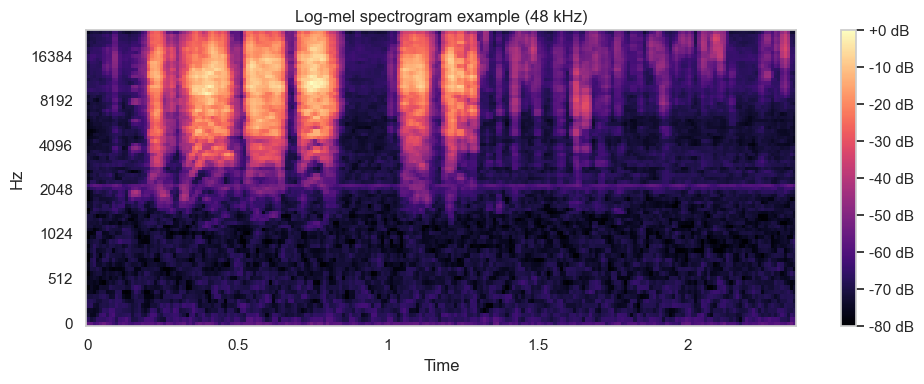

Example file: 69809.wav | original sr=250000


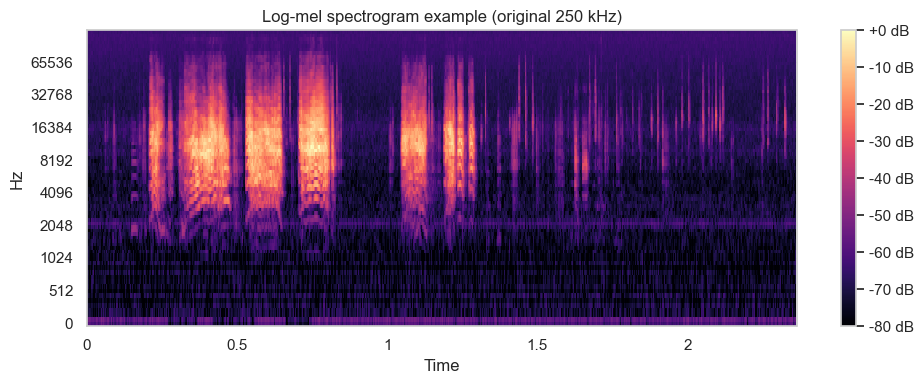

In [14]:
# visualize one mel-spectrogram
example_fn = ann_small['File Name'].iloc[0]
mel_path = DERIVED_MELS_48K / (Path(example_fn).stem + '.npy')
mel = np.load(mel_path)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, sr=TARGET_SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-mel spectrogram example (48 kHz)')
plt.tight_layout()
plt.show()

# also visualize mel-spectrogram for the original 250 kHz waveform of the same example
wav_path = AUDIO_DIR / example_fn
y_250k, sr_250k = librosa.load(wav_path, sr=None)  # keep native 250 kHz
print(f"Example file: {example_fn} | original sr={sr_250k}")

mel_250 = librosa.feature.melspectrogram(
    y=y_250k,
    sr=sr_250k,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    fmax=sr_250k // 2,
)
mel_250_db = librosa.power_to_db(mel_250, ref=np.max).astype(np.float32)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel_250_db,
    sr=sr_250k,
    hop_length=HOP_LENGTH,
    x_axis='time',
    y_axis='mel',
)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-mel spectrogram example (original 250 kHz)')
plt.tight_layout()
plt.show()
